In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

In [3]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [3]:
import tensorflow as tf

# Check GPUs available
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {gpus}")

# Check if TensorFlow is currently executing eagerly (which means operations are executed as they are defined and is the default mode in TF 2.x)
print(f"Eager execution: {tf.executing_eagerly()}")

# If you have GPUs listed and eager execution is enabled, then operations should automatically run on the GPU if possible.
# To test if TensorFlow will place tensors and operations on the GPU by default, you can create a simple operation and see where it is placed:
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        print(a.device)
else:
    print("No GPU found!")

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution: True
/job:localhost/replica:0/task:0/device:GPU:0


2024-04-10 23:34:13.317328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 23:34:13.350887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 23:34:13.351156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# This is the list that will hold all of the data (data22 and MC)

datasets = []
pass_HLT = []
tags = ['HLT_objects', 'L1_objects', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']

## Collect EB Data

In [5]:
# Read EB file
with h5py.File('../../../../ntuples/AOD_EB_ntuples_04-10-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)

# Concatenate L1 data
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)

# Indices of events that passed L1
pass_L1_idxs = (pass_L1_unprescaled == 1)

In [6]:
# Determine what factor to scale the weights
num_HLT = np.sum(EB_weights[pass_L1_idxs])
num_zb = np.sum(EB_weights[~pass_L1_idxs])

print(f'(weighted) number of HLT events: {num_HLT}')
print(f'(weighted) number of zerobias events: {num_zb}')

f = (0.2 * num_HLT)/(0.8 * num_zb) # Scaling factor on zb weights such that zb events are 0.2 of training data
print(f'zerobias scaling factor: {f}')

(weighted) number of HLT events: 157337741.5326
(weighted) number of zerobias events: 95436332543.497
zerobias scaling factor: 0.00041215367706237617


In [7]:
# Scale the weights of the zerobias data
pass_L1_idxs = (pass_L1_unprescaled == 1) # Indices of events that passed L1
t_weights = np.copy(EB_weights) # event weights for training
t_weights[~pass_L1_idxs] *= 0

# Remove E and append data to datasets list
datasets.append(HLT_objects[:, :, [0, 2, 3]])
datasets.append(L1_objects)
pass_HLT.append(pass_HLT_unprescaled)
pass_HLT.append(pass_HLT_unprescaled) # whether the event passed HLT doesn't depend on which set of objects I'm using; append same for each

In [8]:
# Read MC data. Remove E.

filenames = ['HHbbttHadHad.h5', 
             'ZZ4lep.h5', 
             'Ztautau.h5', 
             'jjJZ4.h5', 
             'jjJZ2.h5', 
             'qqa.h5', 
             'HNL7p5_ctau1_eemu.h5',
             'Zprime2EJs.h5',
             'HAHMggfZdZd2l2nu.h5']
data_path = '../../../../ntuples/MC/'

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets.append(combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]])
        pass_HLT.append(pass_HLT_unprescaled[0:min(len(combined_data), 100000)])

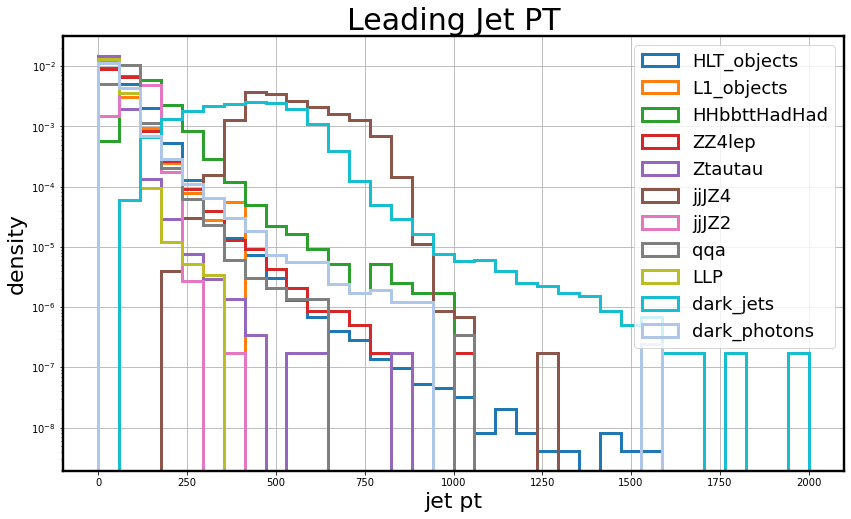

In [9]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 2000, 35)
#bins=50

for i, tag in enumerate(tags):
    pt = datasets[i][:, 0, 0]
    nonzero_pt = pt[pt > 0]

    if i==0:
        nonzero_weights = t_weights[pt > 0]
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=nonzero_weights)
    else:
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Leading Jet PT', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [10]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for i, data in enumerate(datasets):

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [11]:
"""Normalize pt """
for i, data in enumerate(datasets):
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= sum_pt

In [12]:
for i, dataset in enumerate(datasets):
    print(f'{tags[i]}: {dataset.shape}')

HLT_objects: (997315, 20, 3)
L1_objects: (997315, 20, 3)
HHbbttHadHad: (20000, 20, 3)
ZZ4lep: (100000, 20, 3)
Ztautau: (100000, 20, 3)
jjJZ4: (100000, 20, 3)
jjJZ2: (100000, 20, 3)
qqa: (50000, 20, 3)
LLP: (10000, 20, 3)
dark_jets: (100000, 20, 3)
dark_photons: (70000, 20, 3)


In [13]:
# Flatten ndarrays for use in DNN

for i, data in enumerate(datasets):
    datasets[i] = np.reshape(data, newshape=(-1, 60))

for i, data in enumerate(datasets):
    print(f'{tags[i]}: {data.shape}')

HLT_objects: (997315, 60)
L1_objects: (997315, 60)
HHbbttHadHad: (20000, 60)
ZZ4lep: (100000, 60)
Ztautau: (100000, 60)
jjJZ4: (100000, 60)
jjJZ2: (100000, 60)
qqa: (50000, 60)
LLP: (10000, 60)
dark_jets: (100000, 60)
dark_photons: (70000, 60)


In [14]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(h_dim_2, activation='relu')(z)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

In [16]:
# Make train, test, and val splits
# TRAIN_SIZE = 0.5
# VAL_SIZE = 0.1
# TEST_1_SIZE = 0.2
# TEST_2_SIZE = 0.2

random_seed = 0 # random seed for replication between notebooks

# Split indices
indices = np.arange(len(datasets[0]))
train_indices, temp_indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
val_indices, test_indices = train_test_split(temp_indices, train_size=0.2, random_state=random_seed)  # Adjust size as needed
test_1_indices, test_2_indices = train_test_split(test_indices, train_size=0.5, random_state=random_seed)

# Train splits
X_HLT_train = datasets[0][train_indices]
X_L1_train = datasets[1][train_indices]
weights_train = t_weights[train_indices]
pass_HLT_train = pass_HLT[0][train_indices]
pass_L1_idxs_train = pass_L1_idxs[train_indices]
EB_weights_train = EB_weights[train_indices]


# Val splits
X_HLT_val = datasets[0][val_indices]
X_L1_val = datasets[1][val_indices]
weights_val = t_weights[val_indices]
pass_HLT_val = pass_HLT[0][val_indices]
pass_L1_idxs_val = pass_L1_idxs[val_indices]
EB_weights_val = EB_weights[val_indices]


# Test 1 splits
X_HLT_test_1 = datasets[0][test_1_indices]
X_L1_test_1 = datasets[1][test_1_indices]
weights_test_1 = t_weights[test_1_indices]
pass_HLT_test_1 = pass_HLT[0][test_1_indices]
pass_L1_idxs_test_1 = pass_L1_idxs[test_1_indices]
EB_weights_test_1 = EB_weights[test_1_indices]


# Test_2 splits
X_HLT_test_2 = datasets[0][test_2_indices]
X_L1_test_2 = datasets[1][test_2_indices]
weights_test_2 = t_weights[test_2_indices]
pass_HLT_test_2 = pass_HLT[0][test_2_indices]
pass_L1_idxs_test_2 = pass_L1_idxs[test_2_indices]
EB_weights_test_2 = EB_weights[test_2_indices]

print(f'X_train: {X_HLT_train.shape}')
print(f'X_val: {X_HLT_val.shape}')
print(f'X_test_1: {X_HLT_test_1.shape}')
print(f'X_test_2: {X_HLT_test_2.shape}')

X_train: (498657, 60)
X_val: (99731, 60)
X_test_1: (199463, 60)
X_test_2: (199464, 60)


In [17]:
# Initialize models
INPUT_DIM = X_HLT_train.shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3

HLT_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
L1_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)

HLT_AE.summary()
L1_AE.summary()

2024-04-15 13:09:20.331947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 13:09:20.799047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 13:09:20.799342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 32)                1952      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
 dense_3 (Dense)             (None, 8)                 32        
                                                                 
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dense_5 (Dense)             (None, 60)                1980  

In [18]:
HLT_AE.compile(optimizer='adam', loss=loss_fn)
L1_AE.compile(optimizer='adam', loss=loss_fn)

In [19]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [20]:
NUM_EPOCHS = 150
BATCH_SIZE = 512

In [25]:
# train HLT model
history = HLT_AE.fit(x=X_HLT_train, y=X_HLT_train, validation_data=(X_HLT_val, X_HLT_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights_train)

Epoch 1/150
974/974 [==============================] - 6s 4ms/step - loss: 143.1250 - val_loss: 0.8732 - lr: 0.0010
Epoch 2/150
974/974 [==============================] - 3s 3ms/step - loss: 134.3002 - val_loss: 0.8483 - lr: 0.0010
Epoch 3/150
974/974 [==============================] - 3s 3ms/step - loss: 131.3123 - val_loss: 0.8346 - lr: 0.0010
Epoch 4/150
974/974 [==============================] - 3s 3ms/step - loss: 129.5932 - val_loss: 0.8248 - lr: 0.0010
Epoch 5/150
974/974 [==============================] - 3s 3ms/step - loss: 127.8888 - val_loss: 0.8137 - lr: 0.0010
Epoch 6/150
974/974 [==============================] - 3s 3ms/step - loss: 125.9081 - val_loss: 0.8010 - lr: 0.0010
Epoch 7/150
974/974 [==============================] - 3s 3ms/step - loss: 123.9967 - val_loss: 0.7885 - lr: 0.0010
Epoch 8/150
974/974 [==============================] - 3s 3ms/step - loss: 122.1856 - val_loss: 0.7774 - lr: 0.0010
Epoch 9/150
974/974 [==============================] - 3s 3ms/step - los

In [26]:
#HLT_AE.save_weights('./trained_models/EB_HLT_v1.keras')

In [21]:
HLT_AE.load_weights('./trained_models/EB_HLT_v1.keras')

In [28]:
# train L1 model
history = L1_AE.fit(x=X_L1_train, y=X_L1_train, validation_data=(X_L1_val, X_L1_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights_train)

Epoch 1/150
974/974 [==============================] - 5s 4ms/step - loss: 66.7268 - val_loss: 0.3684 - lr: 0.0010
Epoch 2/150
974/974 [==============================] - 3s 3ms/step - loss: 56.8146 - val_loss: 0.3598 - lr: 0.0010
Epoch 3/150
974/974 [==============================] - 3s 3ms/step - loss: 55.7626 - val_loss: 0.3547 - lr: 0.0010
Epoch 4/150
974/974 [==============================] - 3s 3ms/step - loss: 55.0906 - val_loss: 0.3516 - lr: 0.0010
Epoch 5/150
974/974 [==============================] - 3s 3ms/step - loss: 54.4803 - val_loss: 0.3467 - lr: 0.0010
Epoch 6/150
974/974 [==============================] - 3s 3ms/step - loss: 53.9060 - val_loss: 0.3439 - lr: 0.0010
Epoch 7/150
974/974 [==============================] - 3s 3ms/step - loss: 53.5901 - val_loss: 0.3444 - lr: 0.0010
Epoch 8/150
974/974 [==============================] - 3s 3ms/step - loss: 53.3500 - val_loss: 0.3410 - lr: 0.0010
Epoch 9/150
974/974 [==============================] - 3s 3ms/step - loss: 53.03

In [29]:
#L1_AE.save_weights('./trained_models/EB_L1_v1.keras')

In [22]:
L1_AE.load_weights('./trained_models/EB_L1_v1.keras')

## Evaluate Model

In [23]:
# From the first test split, collect only the HLT data (only events that passed L1)
HLT_bkg_data = X_HLT_test_1[pass_L1_idxs_test_1]
L1_bkg_data = X_L1_test_1[pass_L1_idxs_test_1]
bkg_weights = weights_test_1[pass_L1_idxs_test_1]
bkg_pass_HLT = pass_HLT_test_1[pass_L1_idxs_test_1]

# From the second test split, separate HLT data from zerobias dat
HLT_test_data = X_HLT_test_2[pass_L1_idxs_test_2]
L1_test_data = X_L1_test_2[pass_L1_idxs_test_2]
HLT_test_weights = weights_test_2[pass_L1_idxs_test_2]
HLT_pass_HLT = pass_HLT_test_2[pass_L1_idxs_test_2]

HLT_zb_test_data = X_HLT_test_2[~pass_L1_idxs_test_2]
L1_zb_test_data = X_L1_test_2[~pass_L1_idxs_test_2]
zb_test_weights = EB_weights_test_2[~pass_L1_idxs_test_2] # use the EB weight instead of the scaled training weights
zb_pass_HLT = pass_HLT_test_2[~pass_L1_idxs_test_2]

In [24]:
# Pass the HLT test split and HLT signal datsets through the model
HLT_tags = ['data (background)', 'HLT', 'zerobias', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']

HLT_model_outputs = []
HLT_y_true = []

# pass the background and test data thruogh the model
HLT_model_outputs.append(HLT_AE.predict(HLT_bkg_data))
HLT_y_true.append(HLT_bkg_data)
HLT_model_outputs.append(HLT_AE.predict(HLT_test_data))
HLT_y_true.append(HLT_test_data)
HLT_model_outputs.append(HLT_AE.predict(HLT_zb_test_data))
HLT_y_true.append(HLT_zb_test_data)

# Pass the signals through the model
for i, data in enumerate(datasets):
    if i<=1: continue # skip the HLT and L1 objects

    HLT_y_true.append(data)
    HLT_model_outputs.append(HLT_AE.predict(data))

2188/2188 [==============================] - 4s 2ms/step


In [25]:
# Pass the L1 splits through the model
L1_tags = ['data (background)', 'L1 objects', 'zerobias']

L1_model_outputs = []
L1_y_true = []

L1_model_outputs.append(L1_AE.predict(L1_bkg_data))
L1_y_true.append(L1_bkg_data)
L1_model_outputs.append(L1_AE.predict(L1_test_data))
L1_y_true.append(L1_test_data)
L1_model_outputs.append(L1_AE.predict(L1_zb_test_data))
L1_y_true.append(L1_zb_test_data)

4869/4869 [==============================] - 8s 2ms/step


In [26]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [27]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [28]:
# Calculate the AD scores on test split and signals

HLT_AD_scores = []
L1_AD_scores = []

for i, model_output in enumerate(HLT_model_outputs):
    HLT_AD_scores.append(AD_score(HLT_y_true[i], model_output))

for i, model_output in enumerate(L1_model_outputs):
    L1_AD_scores.append(AD_score(L1_y_true[i], model_output))

In [29]:
# Keep track of the weights for each set of data (the weights for the signals are all 1)
# as well as which events passed the HLT
weights_list = []
pass_HLT_list = []

# Append for different EB splits
weights_list.append(bkg_weights)
weights_list.append(HLT_test_weights)
weights_list.append(zb_test_weights)
pass_HLT_list.append(bkg_pass_HLT)
pass_HLT_list.append(HLT_pass_HLT)
pass_HLT_list.append(zb_pass_HLT)

# Append signal weights (all ones)
for i, data in enumerate(datasets):
    if i <= 1: continue # Skip HLT and L1 objects

    weights_list.append(np.ones(data.shape[0]))
    pass_HLT_list.append(pass_HLT[i])
    

<Figure size 1296x720 with 0 Axes>

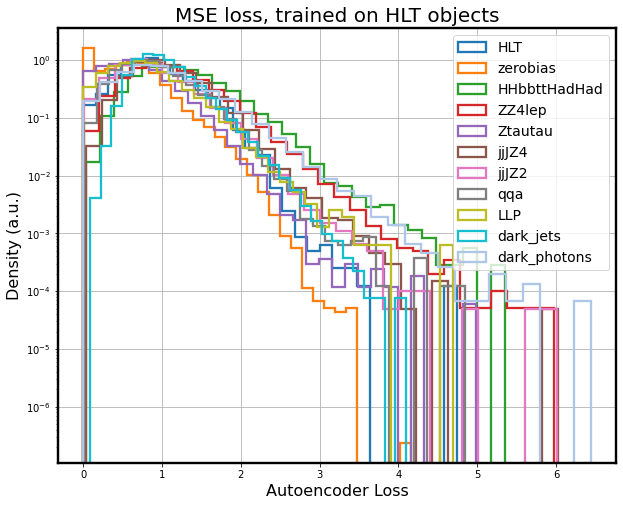

In [30]:
# Plot a histogram of the HLT AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for i, tag in enumerate(HLT_tags):
    if i==0: continue # skip background data
    plt.hist(HLT_AD_scores[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights_list[i])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on HLT objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

<Figure size 1296x720 with 0 Axes>

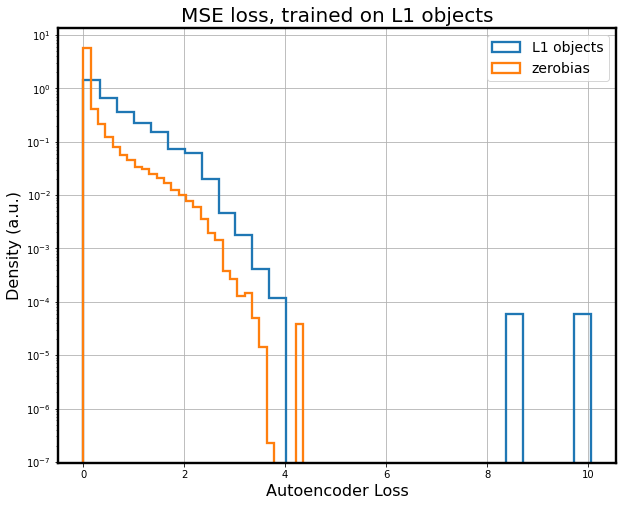

In [31]:
# Plot a histogram of the L1 AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for i, tag in enumerate(L1_tags):
    if i==0: continue # skip background data
    plt.hist(L1_AD_scores[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights_list[i])


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss, trained on L1 objects', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

<Figure size 1296x720 with 0 Axes>

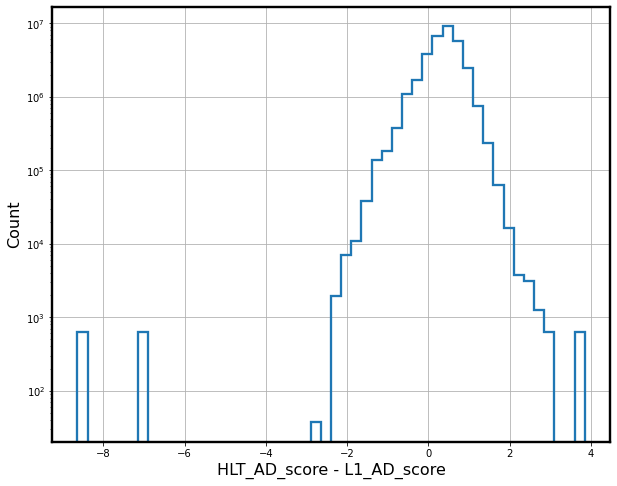

In [36]:
# Plot a histogram of the L1 AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=50
plt.figure(figsize=(10,8))

plt.hist(HLT_AD_scores[1] - L1_AD_scores[1], bins=bins, label='', density = False, histtype='step', fill=False, linewidth=2.3, weights=weights_list[1])


plt.yscale('log')
plt.xlabel("HLT_AD_score - L1_AD_score", fontsize=16)
plt.ylabel("Count", fontsize=16)
#plt.title('HLT_AD_score - L1_AD_score', fontsize=20)
#plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

HLT: TPR at FPR of 10^-4 is 0.0002 with threshold 3.0803
threshold FPR: 9.912614524331798e-05
zerobias: TPR at FPR of 10^-4 is 0.00002 with threshold 3.0803
HHbbttHadHad: TPR at FPR of 10^-4 is 0.00495 with threshold 3.0803
ZZ4lep: TPR at FPR of 10^-4 is 0.00290 with threshold 3.0803
Ztautau: TPR at FPR of 10^-4 is 0.00022 with threshold 3.0803
jjJZ4: TPR at FPR of 10^-4 is 0.00095 with threshold 3.0803
jjJZ2: TPR at FPR of 10^-4 is 0.00073 with threshold 3.0803
qqa: TPR at FPR of 10^-4 is 0.00060 with threshold 3.0803
LLP: TPR at FPR of 10^-4 is 0.00120 with threshold 3.0803
dark_jets: TPR at FPR of 10^-4 is 0.00029 with threshold 3.0803
dark_photons: TPR at FPR of 10^-4 is 0.00429 with threshold 3.0803


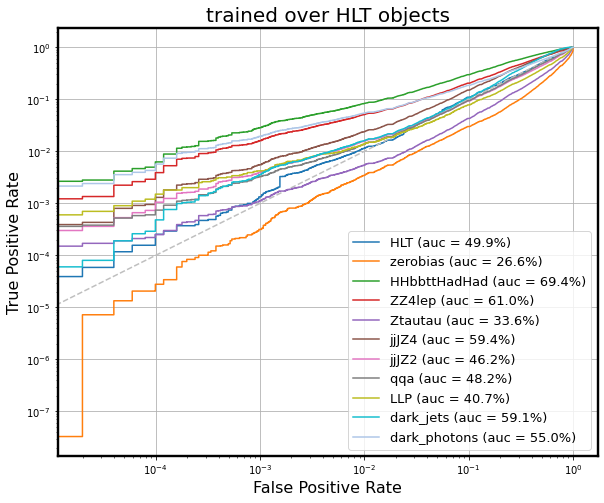

In [37]:
# Plot the HLT ROC curves

target_background = np.zeros(HLT_AD_scores[0].shape[0])

plt.figure(figsize=(8.5,6.8))

for i, label in enumerate(HLT_tags):
    if i==0: continue # skip background data
    
    # Combine true labels, anomaly=1 and background=0
    trueVal = np.concatenate((np.ones(HLT_AD_scores[i].shape[0]), target_background))
    
    # Combine predictions from current dataset and background
    predVal_loss = np.concatenate((HLT_AD_scores[i], HLT_AD_scores[0]))
    
    # Include weights for the EB data and assign no weight (or equal weight) for the other dataset
    # if i == 0:  # For the EB data
    #     sample_weights = np.concatenate((weights_test_2, weights_test_1))
    # else:  # For the MC datasets, assume equal weight
    #     sample_weights = np.concatenate((np.ones(AD_scores[i+1].shape[0]), weights_test_1))

    sample_weights = np.concatenate((weights_list[i], weights_list[0]))

    # Calculate ROC curve and AUC, including weights
    fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Plot ROC curve
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (label, auc_loss*100.), linewidth=1.5)

    # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
    if i ==1: 
        target_fpr = 10**-4
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.4f} with threshold {threshold_loss[idx]:.4f}")
        print(f"threshold FPR: {fpr_loss[idx]}")
        HLT_threshold = threshold_loss[idx]
        plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
        #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value
    else:
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")

HLT_fpr_loss = np.copy(fpr_loss)
HLT_threshold_loss = np.copy(threshold_loss)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over HLT objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

L1 objects: TPR at FPR of 10^-4 is 0.0001 with threshold 3.4587
threshold FPR: 8.167250289985377e-05
zerobias: TPR at FPR of 10^-4 is 0.00001 with threshold 3.4587


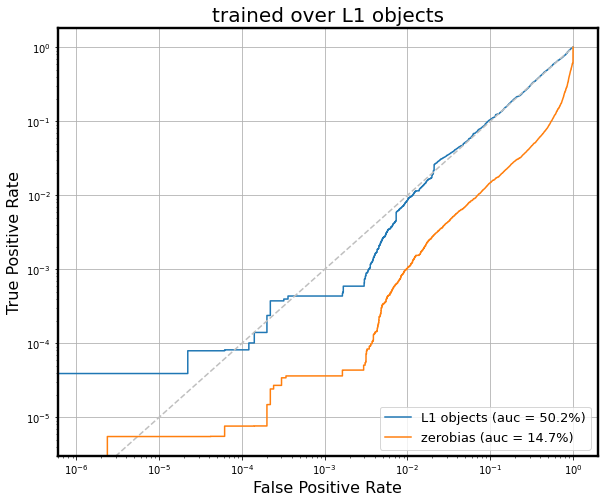

In [38]:
# Plot the L1 ROC curves

target_background = np.zeros(L1_AD_scores[0].shape[0])

plt.figure(figsize=(8.5,6.8))

for i, label in enumerate(L1_tags):
    if i==0: continue # skip background data
    
    # Combine true labels, anomaly=1 and background=0
    trueVal = np.concatenate((np.ones(L1_AD_scores[i].shape[0]), target_background))
    
    # Combine predictions from current dataset and background
    predVal_loss = np.concatenate((L1_AD_scores[i], L1_AD_scores[0]))

    sample_weights = np.concatenate((weights_list[i], weights_list[0]))

    # Calculate ROC curve and AUC, including weights
    fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Plot ROC curve
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (label, auc_loss*100.), linewidth=1.5)

    # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
    if i ==1: 
        target_fpr = 10**-4
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.4f} with threshold {threshold_loss[idx]:.4f}")
        print(f"threshold FPR: {fpr_loss[idx]}")
        L1_threshold = threshold_loss[idx]
        plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
        #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value
    else:
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")

L1_fpr_loss = np.copy(fpr_loss)
L1_threshold_loss = np.copy(threshold_loss)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.title('trained over L1 objects', fontsize=20)

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

In [39]:
# now I need to figure out, at some specific FPR, the overlap between HLT and the L1

In [40]:
HLT_anomaly_idxs = HLT_AD_scores[1] > HLT_threshold
L1_anomaly_idxs = L1_AD_scores[1] > L1_threshold

num_overlaps = np.sum(np.bitwise_and(HLT_anomaly_idxs, L1_anomaly_idxs))
num_HLT_anomalies = np.sum(HLT_anomaly_idxs)
num_L1_anomalies = np.sum(L1_anomaly_idxs)

# Calculate the fractions
f_HLT = (num_overlaps / num_HLT_anomalies)
f_L1 = (num_overlaps / num_L1_anomalies)

print(f'number of events that both the HLT and L1 models flagged as anomalous: {num_overlaps}')
print(f'out of the HLT anomalies, what fraction are also L1 anomalies? {f_HLT}')
print(f'out of the L1 anomalies, what fraction are also HLT anomalies? {f_L1}')

number of events that both the HLT and L1 models flagged as anomalous: 0
out of the HLT anomalies, what fraction are also L1 anomalies? 0.0
out of the L1 anomalies, what fraction are also HLT anomalies? 0.0


In [41]:
print(f'number of L1 anomalies: {num_L1_anomalies}')
print(f'number of HLT anomalies: {num_HLT_anomalies}')

number of L1 anomalies: 7
number of HLT anomalies: 8


In [76]:
# Let's take a closer look at these anomalies
HLT_anomalies = HLT_y_true[1][HLT_anomaly_idxs]
HLT_anom_outputs = HLT_model_outputs[1][HLT_anomaly_idxs]
L1_anomalies = L1_y_true[1][L1_anomaly_idxs]
L1_anom_outputs = L1_model_outputs[1][L1_anomaly_idxs]

print(f'Anomalies found by model trained on HLT objects:')
for i in range(len(HLT_anomalies)):
    print(f'event:\n{HLT_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{HLT_anom_outputs[i].reshape(-1, 20, 3)}')

print(f'Anomalies found by model trained on L1 objects:')
for i in range(len(L1_anomalies)):
    print(f'event:\n{L1_anomalies[i].reshape(-1, 20, 3)}')
    print(f'reconstruction:\n{L1_anom_outputs[i].reshape(-1, 20, 3)}')

Anomalies found by model trained on HLT objects:
event:
[[[ 0.18945431  0.4822886  -0.30662119]
  [ 0.14006709  0.0747449   2.48758316]
  [ 0.10698286 -4.40890455  2.29233575]
  [ 0.10339661 -3.51014018 -0.84333491]
  [ 0.08084805  4.40199375 -2.6154201 ]
  [ 0.05505495  3.06775713 -2.3277216 ]
  [ 0.05356225  4.37638283  0.78126425]
  [ 0.04481367 -2.55221438 -0.62268186]
  [ 0.04245868  1.20024025  2.29764962]
  [ 0.03930756  2.72266507  3.05115509]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.06237572  0.03229186  2.51828933]
  [ 0.01930252  0.49109831 -0.34072194]
  [ 0.          0.          0.        ]]]
reconstruction:
[[[ 0.07721651 -2.3509588   0.15923315]
  [ 0.09922105 -1.2720616   3.5524993 ]
  [ 0.08455377 -3.1708102  -0.55961454]
  [ 0.

In [42]:
# Print HLT overlaps
print(f'MODEL THAT TRAINED OVER HLT OBJECTS::::::')

for i, tag in enumerate(HLT_tags):
    anomaly_idxs = HLT_AD_scores[i] > HLT_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER HLT OBJECTS::::::
-----
data (background):
HLT overlap: 0.0
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 9.052845988457622e-05
number of events that we tagged as anomalous: 4
-----
HLT:
HLT overlap: 0.0
inverse overlap: 1.0056100981767182
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.00018323827847637373
number of events that we tagged as anomalous: 8
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0469798657718121
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 4.492795481531401e-05
number of events that we tagged as anomalous: 7
-----
HHbbttHadHad:
HLT overlap: 0.5757575757575758
inverse overlap: 1.0038627793617216
percentage of events that passed some HLT trigger: 0.54365
percentage of events tha

In [43]:
# Print L1 overlaps
print(f'MODEL THAT TRAINED OVER L1 OBJECTS::::::')

for i, tag in enumerate(L1_tags):
    anomaly_idxs = L1_AD_scores[i] > L1_threshold
    HLT_overlap = 0
    inverse_overlap = 0
    for a, h in zip(anomaly_idxs, pass_HLT_list[i]):
        if a==1 and h==1:
            HLT_overlap += 1
        if a==1 or h==1:
            inverse_overlap += 1

    HLT_overlap /= np.sum(anomaly_idxs)
    inverse_overlap /= np.sum(pass_HLT_list[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_list[i]) / len(pass_HLT_list[i])}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

MODEL THAT TRAINED OVER L1 OBJECTS::::::
-----
data (background):
HLT overlap: 0.2
inverse overlap: 1.0028308563340411
percentage of events that passed some HLT trigger: 0.03197917845422655
percentage of events that we tagged as anomalous: 0.00011316057485572027
number of events that we tagged as anomalous: 5
-----
L1 objects:
HLT overlap: 0.0
inverse overlap: 1.0049088359046283
percentage of events that passed some HLT trigger: 0.03266222313841362
percentage of events that we tagged as anomalous: 0.000160333493666827
number of events that we tagged as anomalous: 7
-----
zerobias:
HLT overlap: 0.0
inverse overlap: 1.0268456375838926
percentage of events that passed some HLT trigger: 0.0009563236096402554
percentage of events that we tagged as anomalous: 2.5673117037322294e-05
number of events that we tagged as anomalous: 4


In [65]:
HLT_rates = []
HLT_num_objects = []
for i, fpr in enumerate(HLT_fpr_loss):
    threshold = HLT_threshold_loss[i]

    anomaly_idxs = (HLT_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = HLT_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    #HLT_num_objects.append(np.average(num_objects_per_event, weights=anom_weights))
    HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    HLT_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(HLT_fpr_loss)}')

/tmp/ipykernel_372/3218523813.py:15: RuntimeWarning: invalid value encountered in double_scalars
  HLT_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))


progress: 1 / 57940
progress: 10001 / 57940
progress: 20001 / 57940
progress: 30001 / 57940
progress: 40001 / 57940
progress: 50001 / 57940


In [66]:
L1_rates = []
L1_num_objects = []
for i, fpr in enumerate(L1_fpr_loss):
    threshold = L1_threshold_loss[i]

    anomaly_idxs = (L1_AD_scores[1] > threshold) # HLT_AD_scores[1] is the test dataset of HLT data
    HLT_acceptance = np.sum(weights_list[1] * pass_HLT_list[1]) / np.sum(weights_list[1])
    HLT_AD_acceptance = np.sum(weights_list[1] * np.bitwise_or(anomaly_idxs, pass_HLT_list[1])) / np.sum(weights_list[1])

    pt_values = L1_y_true[1][anomaly_idxs].reshape(-1, 20, 3)[:, :, 0]
    anom_weights = weights_list[1][anomaly_idxs]
    if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
    num_objects_per_event = np.count_nonzero(pt_values, axis=1)
    L1_num_objects.append(np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    L1_rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)

    if (i % 10000) == 1:
        print(f'progress: {i} / {len(L1_fpr_loss)}')

progress: 1 / 127979
progress: 10001 / 127979
progress: 20001 / 127979
progress: 30001 / 127979
progress: 40001 / 127979
progress: 50001 / 127979
progress: 60001 / 127979
progress: 70001 / 127979
progress: 80001 / 127979
progress: 90001 / 127979
progress: 100001 / 127979
progress: 110001 / 127979
progress: 120001 / 127979


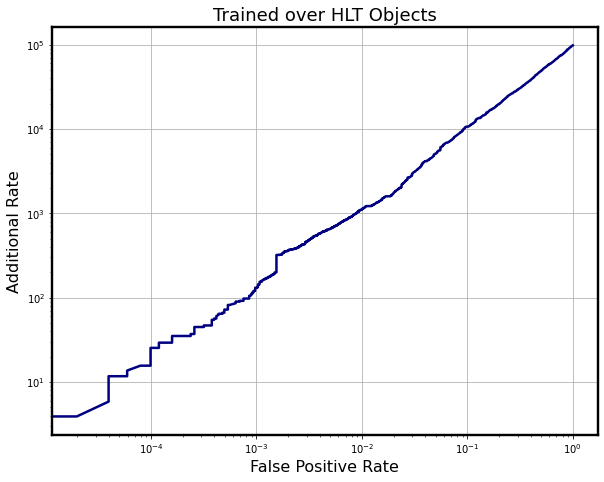

In [67]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

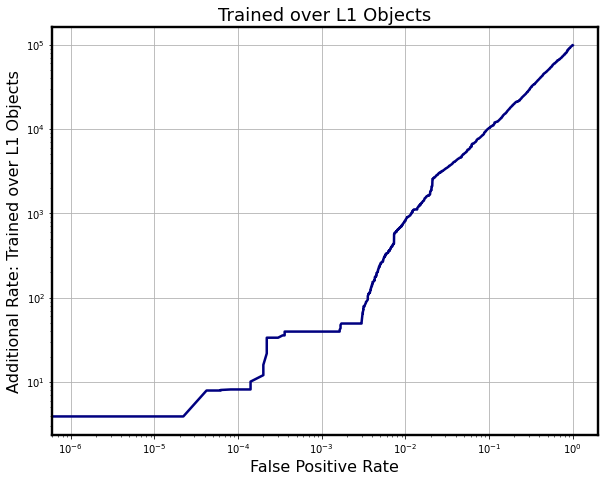

In [68]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("Additional Rate: Trained over L1 Objects", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [69]:
target_fpr = 10**-4
HLT_idx = np.argmin(np.abs(HLT_fpr_loss - target_fpr))
L1_idx = np.argmin(np.abs(L1_fpr_loss - target_fpr))

print(f'Pure rate at fpr=10e-4: {HLT_rates[HLT_idx]} (trained over HLT objects)')
print(f'Pure rate at fpr=10e-4: {L1_rates[L1_idx]} (trained over L1 objects)')

Pure rate at fpr=10e-4: 15.612964742042074 (trained over HLT objects)
Pure rate at fpr=10e-4: 8.156675357946785 (trained over L1 objects)


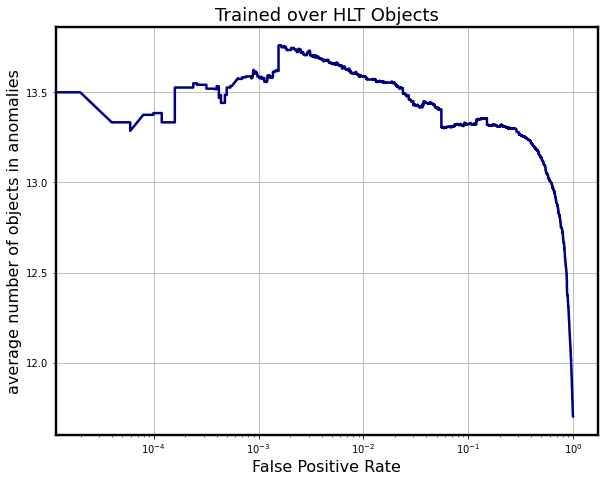

In [72]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(HLT_fpr_loss, HLT_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over HLT Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

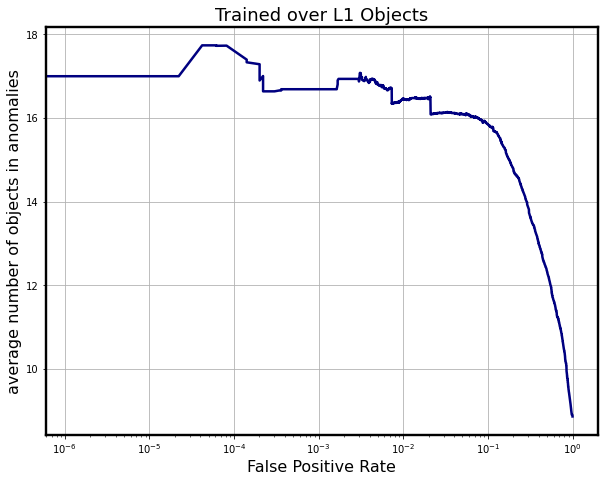

In [73]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(L1_fpr_loss, L1_num_objects, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
#plt.semilogy()

plt.title('Trained over L1 Objects', fontsize=18)
plt.ylabel("average number of objects in anomalies", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()

In [74]:
pt_values = HLT_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
HLT_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with HLT objects: {HLT_num_objs}')

average number of objects per event in the whole test data with HLT objects: 11.692775578449224


In [75]:
pt_values = L1_y_true[1].reshape(-1, 20, 3)[:, :, 0]
anom_weights = weights_list[1]
if np.sum(anom_weights)==0: anom_weights = np.ones(anom_weights.shape)
num_objects_per_event = np.count_nonzero(pt_values, axis=1)
L1_num_objs = (np.sum(num_objects_per_event * anom_weights) / np.sum(anom_weights))
print(f'average number of objects per event in the whole test data with L1 objects: {L1_num_objs}')

average number of objects per event in the whole test data with L1 objects: 8.855968094629004
